# K-Means

## Initialization

The first thing we do for each algorithm will be to try to use it without thinking, just decide a subset of feature based on the undestanding and analysis.

In [101]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with.
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this is a classic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utility.cluster_utility import scale_data, inverse_scale_data
from utility.cluster_utility import k_search


# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

cyclysts_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
print(cyclysts_df.columns)

Index(['_url', 'name', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'avg_points_per_race', 'average_position', 'avg_speed_cyclist',
       'cyclist_age', 'cyclist', 'mean_stamina_index'],
      dtype='object')


Now we decide on which features we can do the clustering

In [102]:
# We will start by keeping all the numerical columns and see where this brings us.
cyclysts_df = cyclysts_df.select_dtypes(include=[np.number])
# drop the rows with missing values
initial_count = cyclysts_df.shape[0]
cyclysts_df = cyclysts_df.dropna()
final_count = cyclysts_df.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {(initial_count - final_count) / initial_count * 100}%')
print(cyclysts_df.columns)

Dropped 3227 rows with missing values
In percentage: 52.6084121291164%
Index(['birth_year', 'weight', 'height', 'bmi', 'race_count', 'total_points',
       'victories_by_points', 'avg_points_per_race', 'average_position',
       'avg_speed_cyclist', 'cyclist_age', 'mean_stamina_index'],
      dtype='object')


Probably we want to remove columns with too high correlation, for example it may not be a good idea to have: weight, height, and bmi

## Normalization

In [103]:
cyc_normalizer, cyc_normalized = scale_data(cyclysts_df)

## Hyperparameter

Now we do the classic plot with the various k 

_Warning_: it is obviously slow, but what can I do?

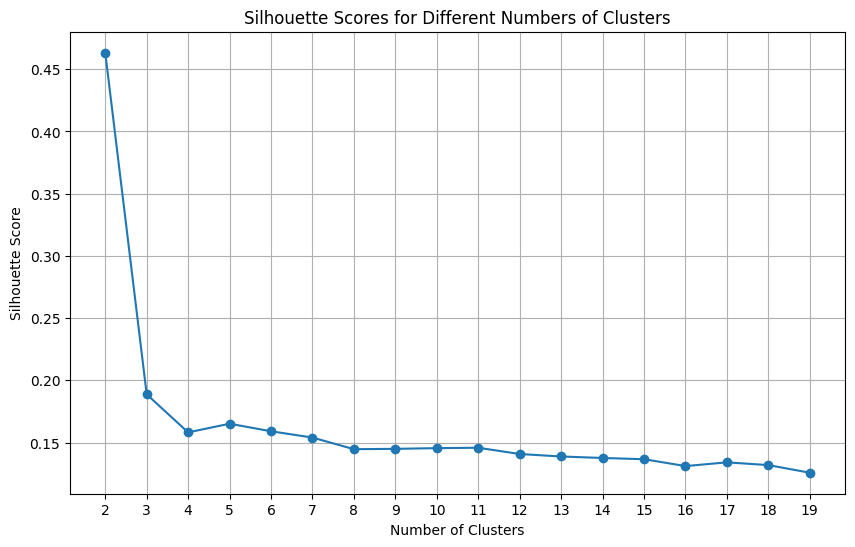

In [104]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 10         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.grid(True)
    plt.show()

## Analysis of the best result

Based on magic we can say that 4 is a good number of clusters. So we try to rerun the algorithm with the best parameters and then we will be able to analize a bit the results

In [105]:
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=N_INIT, init='random')
kmeans.fit(cyc_normalized)
cyclysts_df['cluster'] = kmeans.labels_
#sns.scatterplot(data=cyclysts_df, x="total_points", y="weight", hue=kmeans.labels_)

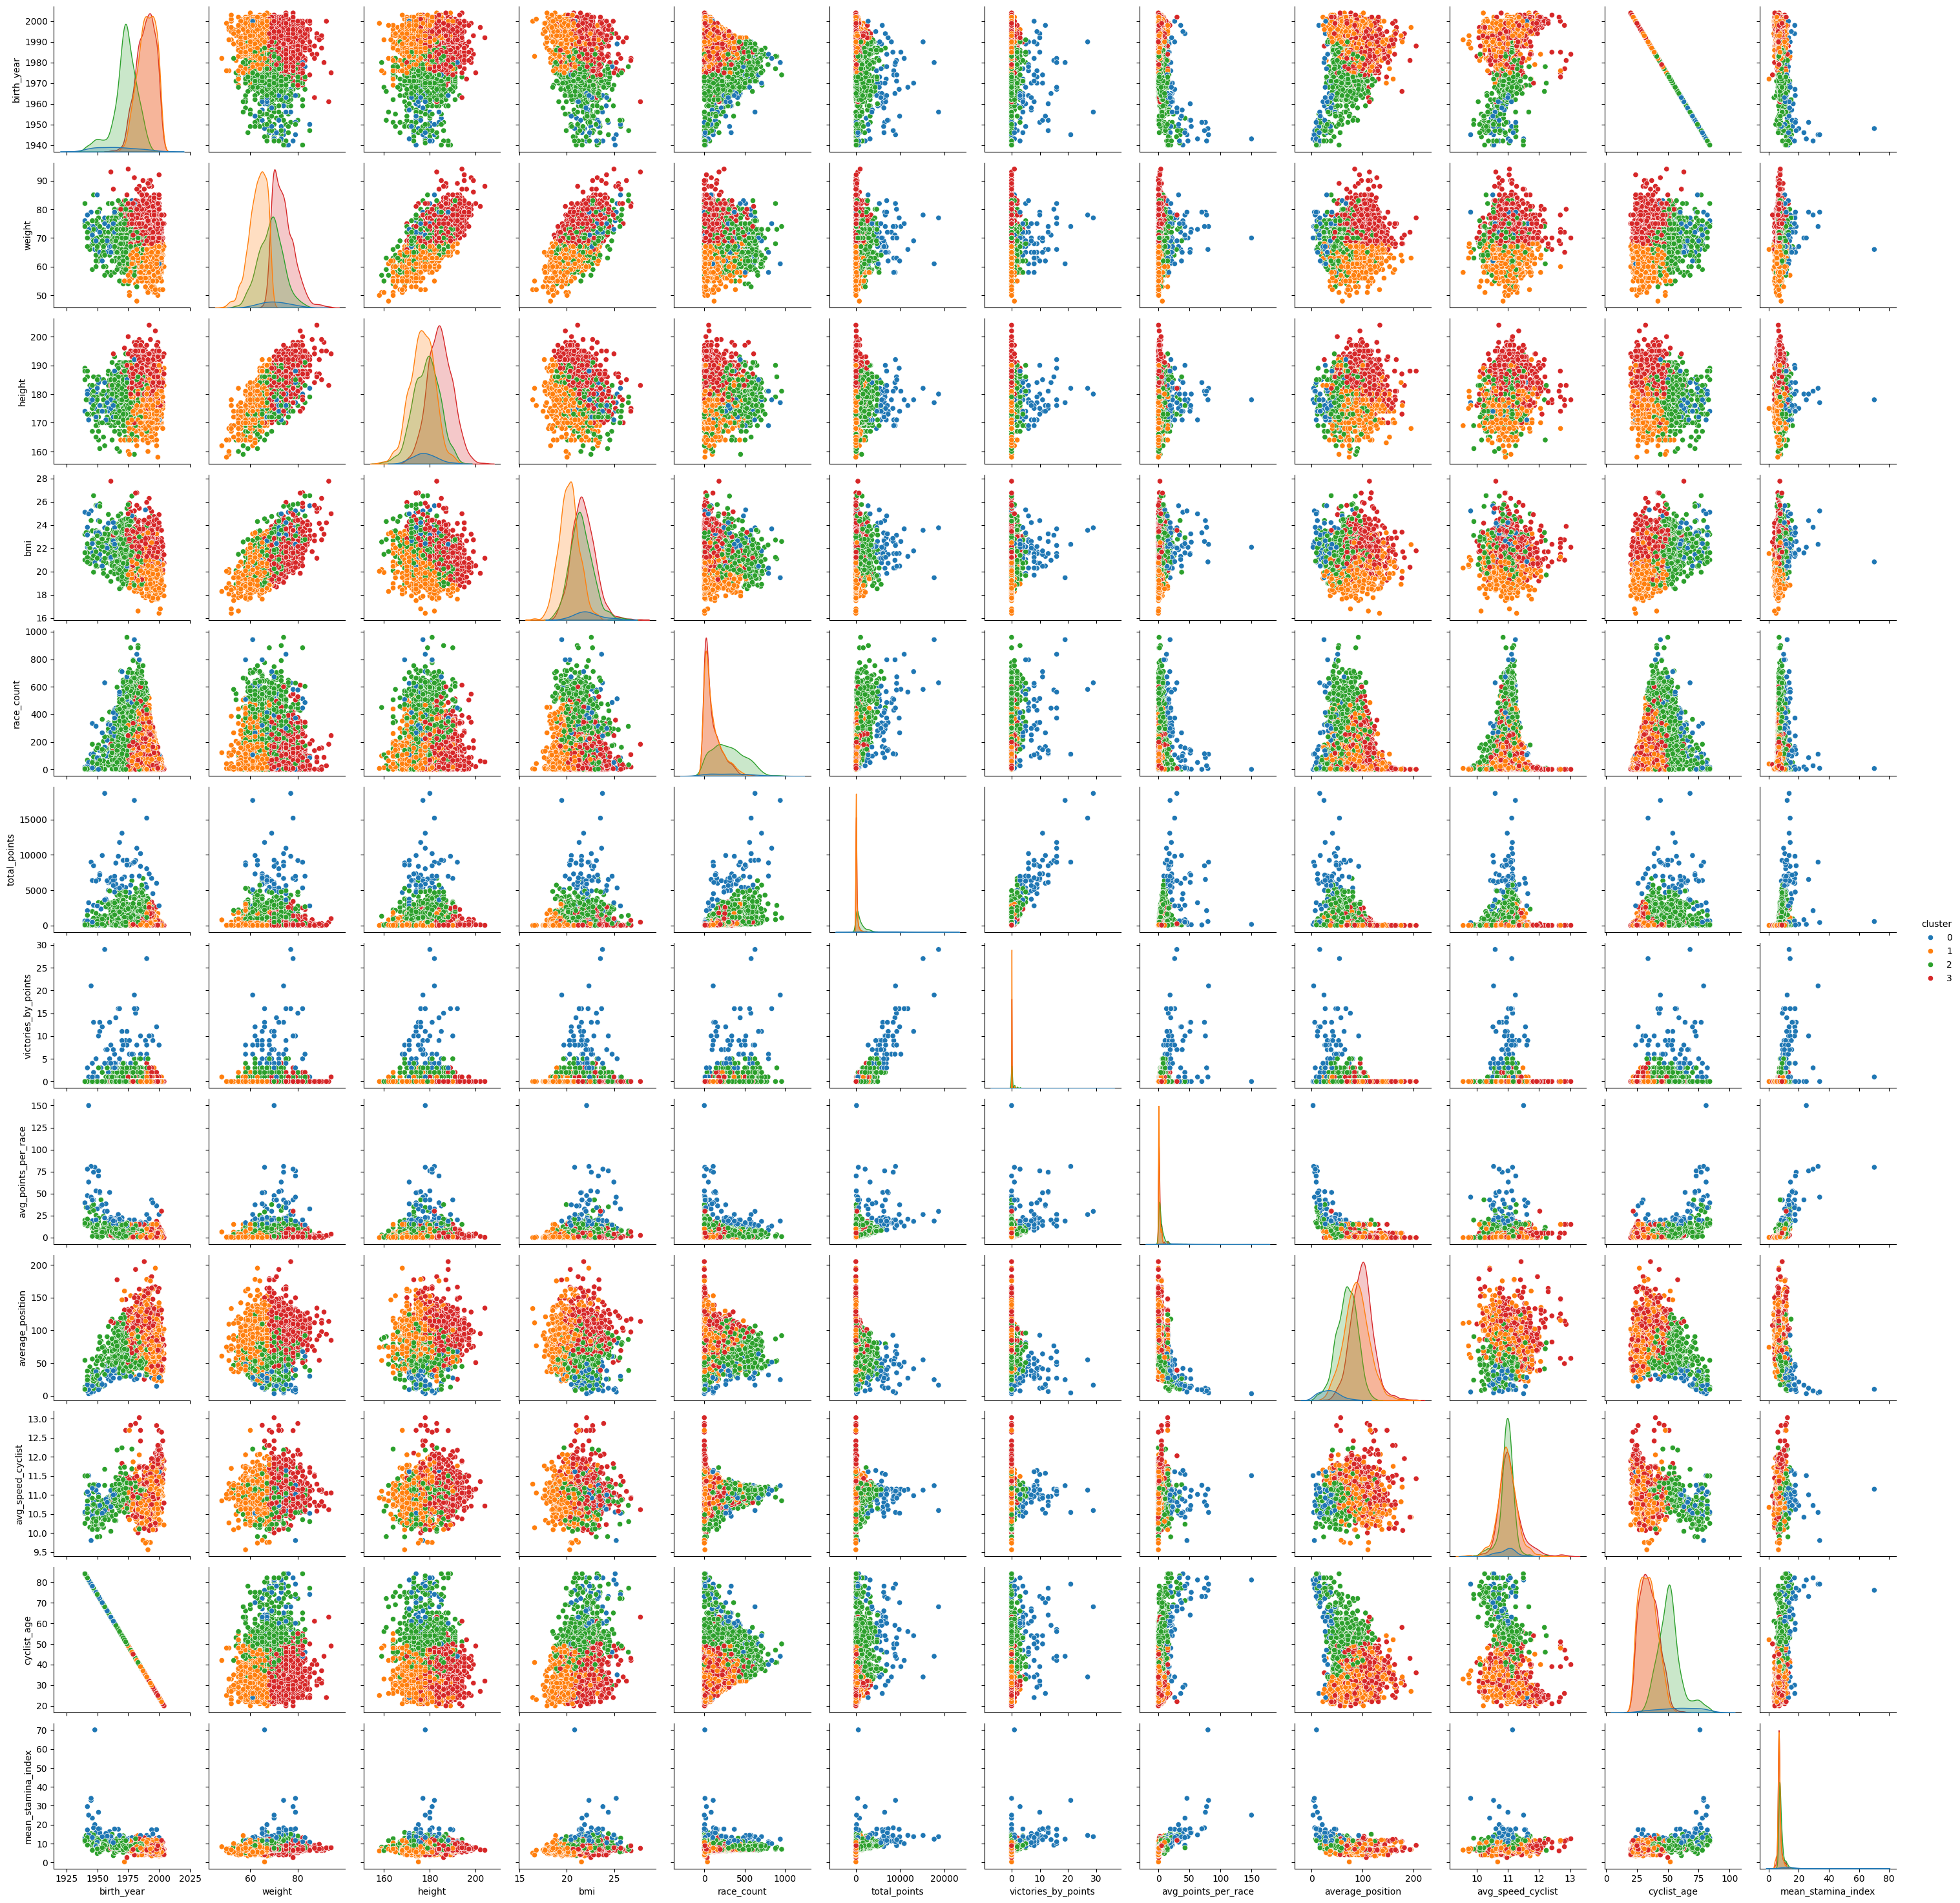

In [106]:
if RUN_SLOW_STUFF:
    sns.pairplot(cyclysts_df, hue='cluster', palette='tab10')
    plt.show()


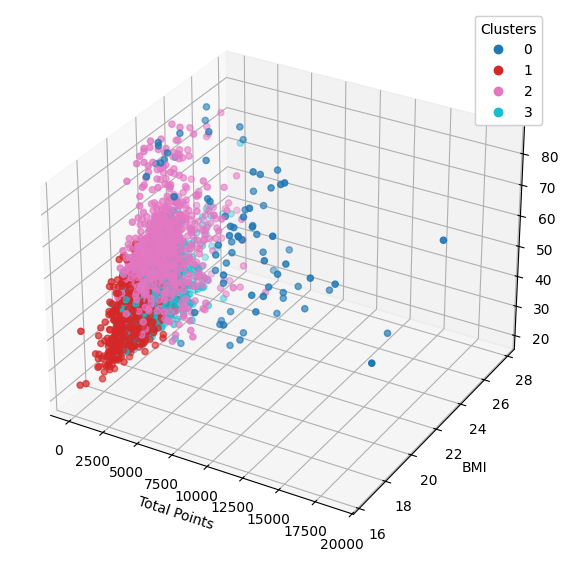

In [107]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(cyclysts_df['total_points'], cyclysts_df['bmi'], cyclysts_df['cyclist_age'], c=cyclysts_df['cluster'], cmap='tab10')

# Labels
ax.set_xlabel('Total Points')
ax.set_ylabel('BMI')
ax.set_zlabel('Height')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

The analysis looks impossible; probably we should remove the outliers of total points because the only meaningful division seems to be that one. But also we will try to remove some redundant columns

**Note** The above one is an old analysis, while still true, the fact that some cyclist that have higher points are in a different cluster wrt the "normal people" is kinda interesting because they can be considered belonging to the "expert" class

## Improvements based on outcome

In this section we still use the classic base, kmeans with no fancy initializaiton but we select fewer columns to analyze (removing the more dependent ones), in the following sessions other approaches will be tested and compared to this one

In [108]:
columns_to_remove = ['height', 'weight', 
                    'victories_by_points', 'avg_points_per_race', 'average_position',
                    'birth_year', # I forgot age was dependent from this and I was puzzled by the presence of a straight line
                    'cluster'
]
# there is someone with super high stamina index, let's remove them
print(f'removing {cyclysts_df[cyclysts_df['mean_stamina_index'] > 20].shape[0]} rows')
cyclysts_df = cyclysts_df[cyclysts_df['mean_stamina_index'] < 20]
small_cyc_df = cyclysts_df.drop(columns=columns_to_remove)
cyc_normalizer, cyc_normalized = scale_data(small_cyc_df)
print(small_cyc_df.columns)

removing 8 rows
Index(['bmi', 'race_count', 'total_points', 'avg_speed_cyclist', 'cyclist_age',
       'mean_stamina_index'],
      dtype='object')


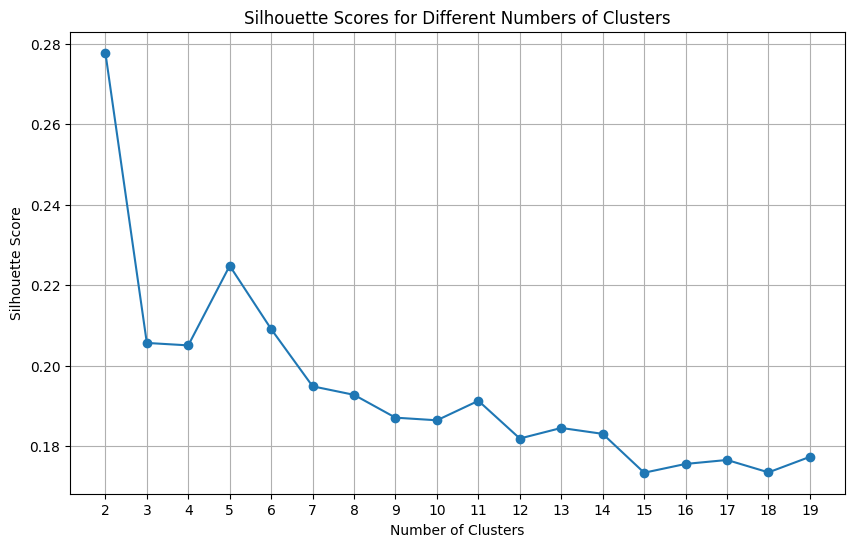

In [109]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 15         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.grid(True)
    plt.show()

In [110]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=N_INIT, init='random')
kmeans.fit(cyc_normalized)
small_cyc_df['cluster'] = kmeans.labels_

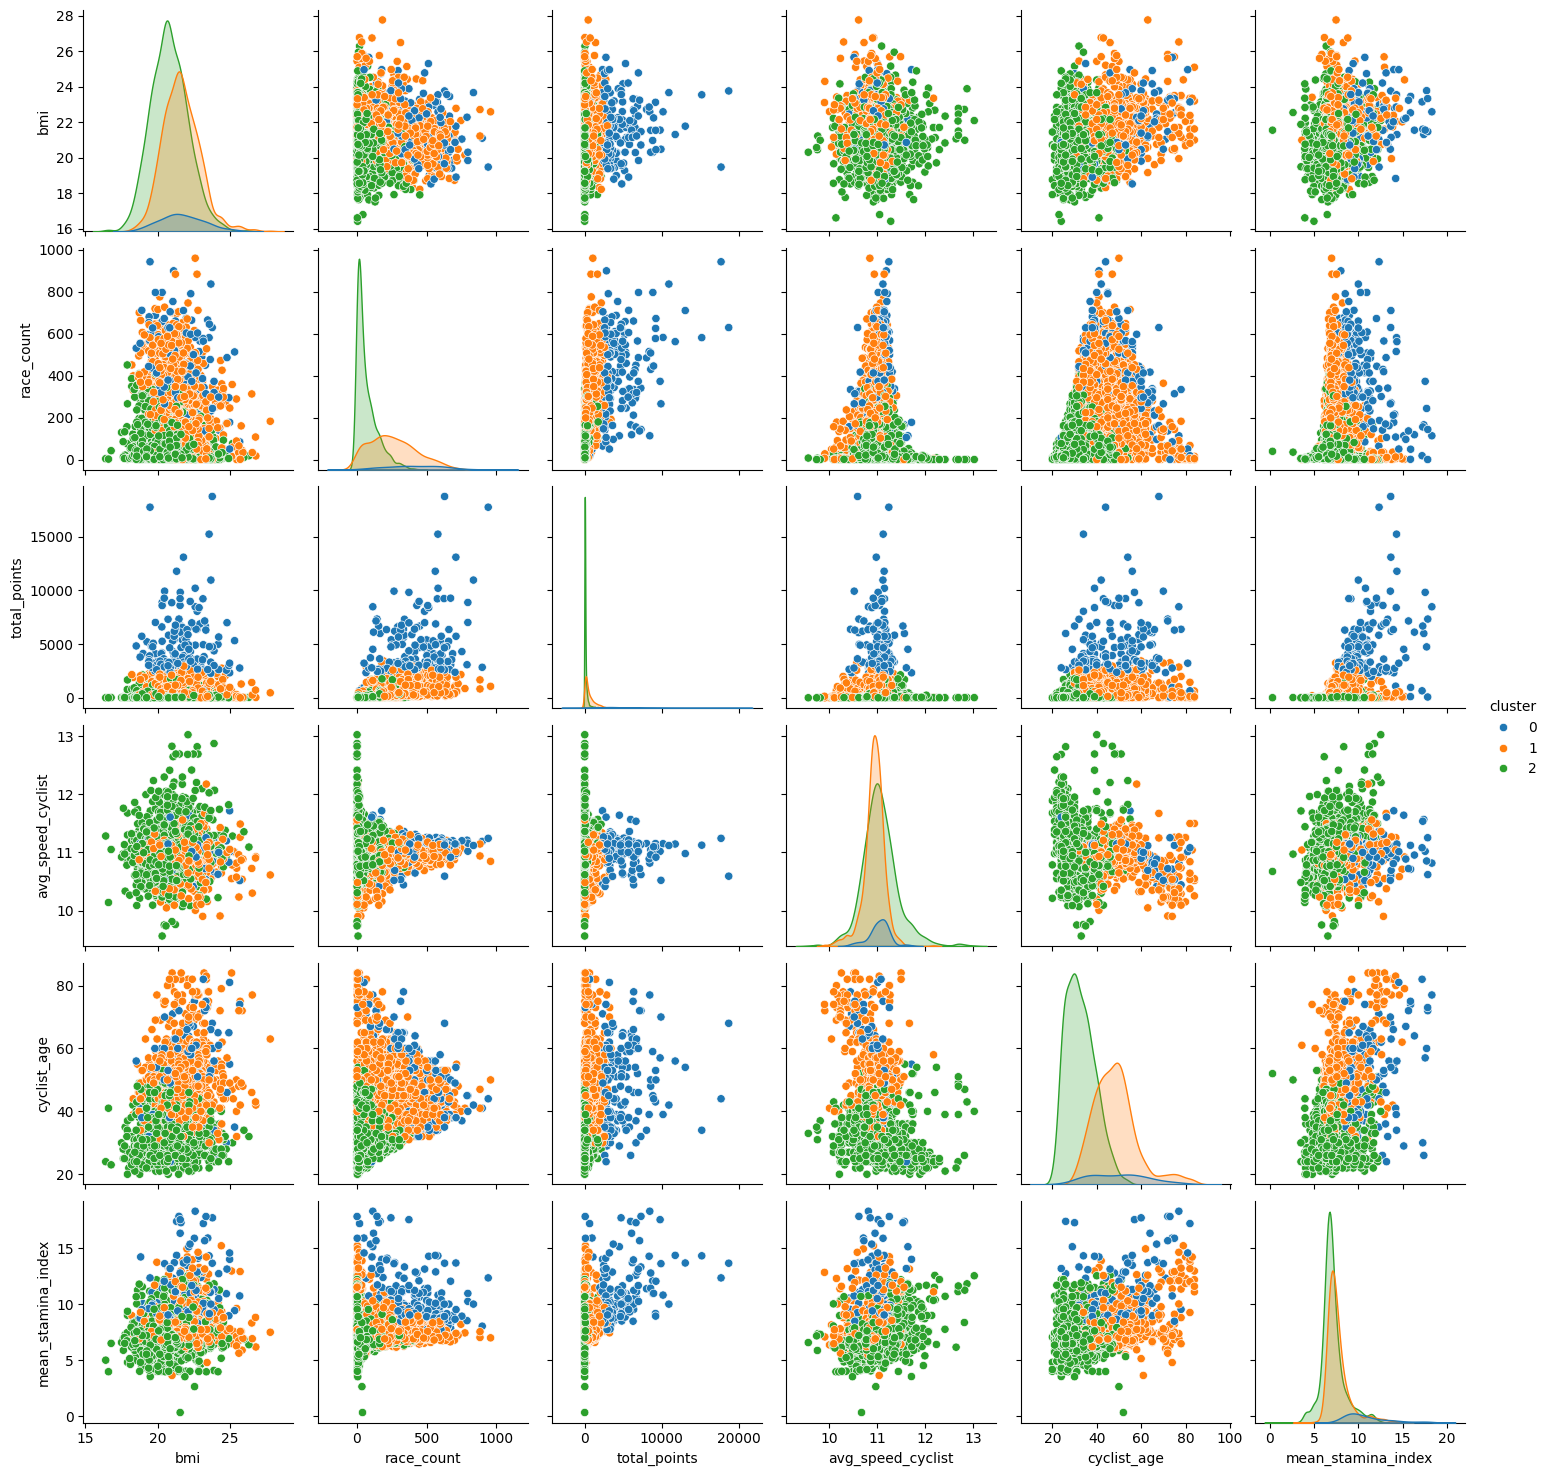

In [111]:
# Inverse transform the cluster centers
centers = cyc_normalizer.inverse_transform(kmeans.cluster_centers_)

if RUN_SLOW_STUFF:
    pairplot = sns.pairplot(small_cyc_df, hue='cluster', palette='tab10')
    plt.show()

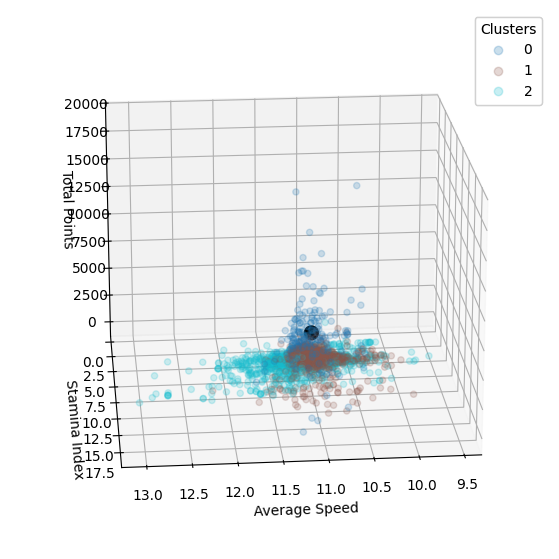

In [112]:
# 3D scatter plot with centers
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

X = 'avg_speed_cyclist'
X_NAME = 'Average Speed'
Y = 'mean_stamina_index'
Y_NAME = 'Stamina Index'
Z = 'total_points'
Z_NAME = 'Total Points'

# Scatter plot
scatter = ax.scatter(small_cyc_df[X], 
                     small_cyc_df[Y], 
                     small_cyc_df[Z], 
                     c=small_cyc_df['cluster'], cmap='tab10', alpha=0.2)

# Plot centers
col = list(small_cyc_df.columns)
#print(col)
ax.scatter(centers[:, col.index(X)], centers[:, col.index(Y)], centers[:, col.index(Z)], c='black', s=100, alpha=1, label='Centers')
#print(centers)
# Labels
ax.set_xlabel(X_NAME)
ax.set_ylabel(Y_NAME)
ax.set_zlabel(Z_NAME)

# Rotate the plot
ax.view_init(elev=20, azim=85)  # Adjust the values as needed

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

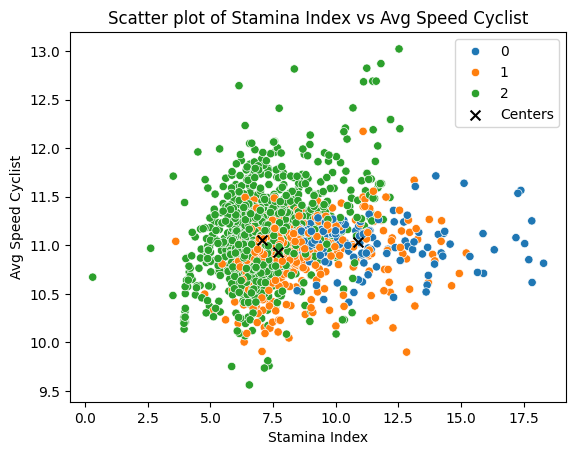

In [114]:

sns.scatterplot(data=small_cyc_df, x='mean_stamina_index', y='avg_speed_cyclist', hue='cluster', palette='tab10')
plt.scatter(centers[:, 5], centers[:, 3], c='black', s=50, alpha=1, label='Centers', marker='x')
plt.title('Scatter plot of Stamina Index vs Avg Speed Cyclist', fontweight='bold')
plt.xlabel('Stamina Index')
plt.ylabel('Avg Speed Cyclist')
plt.legend(title='Cluster')
plt.show()

## Different initialization methods

### kmeans ++

We're really lucky that sklearn give us the possibility to use kmeans++ with just a flag, we'll forever be grateful to the great programmers...

In [115]:
columns_to_remove = ['height', 'weight', 
                    'victories_by_points', 'avg_points_per_race', 'average_position',
                    'birth_year', # I forgot age was dependent from this and I was puzled by the presence of a straight line
                    'cluster'
]
small_cyc_df = cyclysts_df.drop(columns=columns_to_remove)
cyc_normalizer, cyc_normalized = scale_data(small_cyc_df)
print(small_cyc_df.columns)

Index(['bmi', 'race_count', 'total_points', 'avg_speed_cyclist', 'cyclist_age',
       'mean_stamina_index'],
      dtype='object')


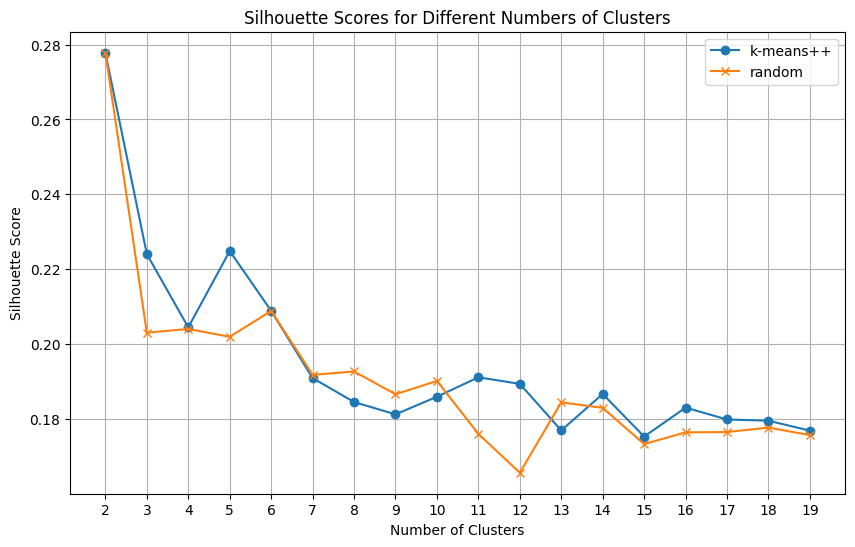

In [116]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 3         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes_plus = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized, init_method='k-means++')
    silhouettes_random = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_plus, marker='o', label='k-means++')
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_random, marker='x', label='random')
    plt.title('Silhouette Scores for Different Numbers of Clusters', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.legend()
    plt.grid(True)
    plt.show()

In [117]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=N_INIT, init='random')
kmeans.fit(cyc_normalized)
small_cyc_df['cluster'] = kmeans.labels_
centers = cyc_normalizer.inverse_transform(kmeans.cluster_centers_)

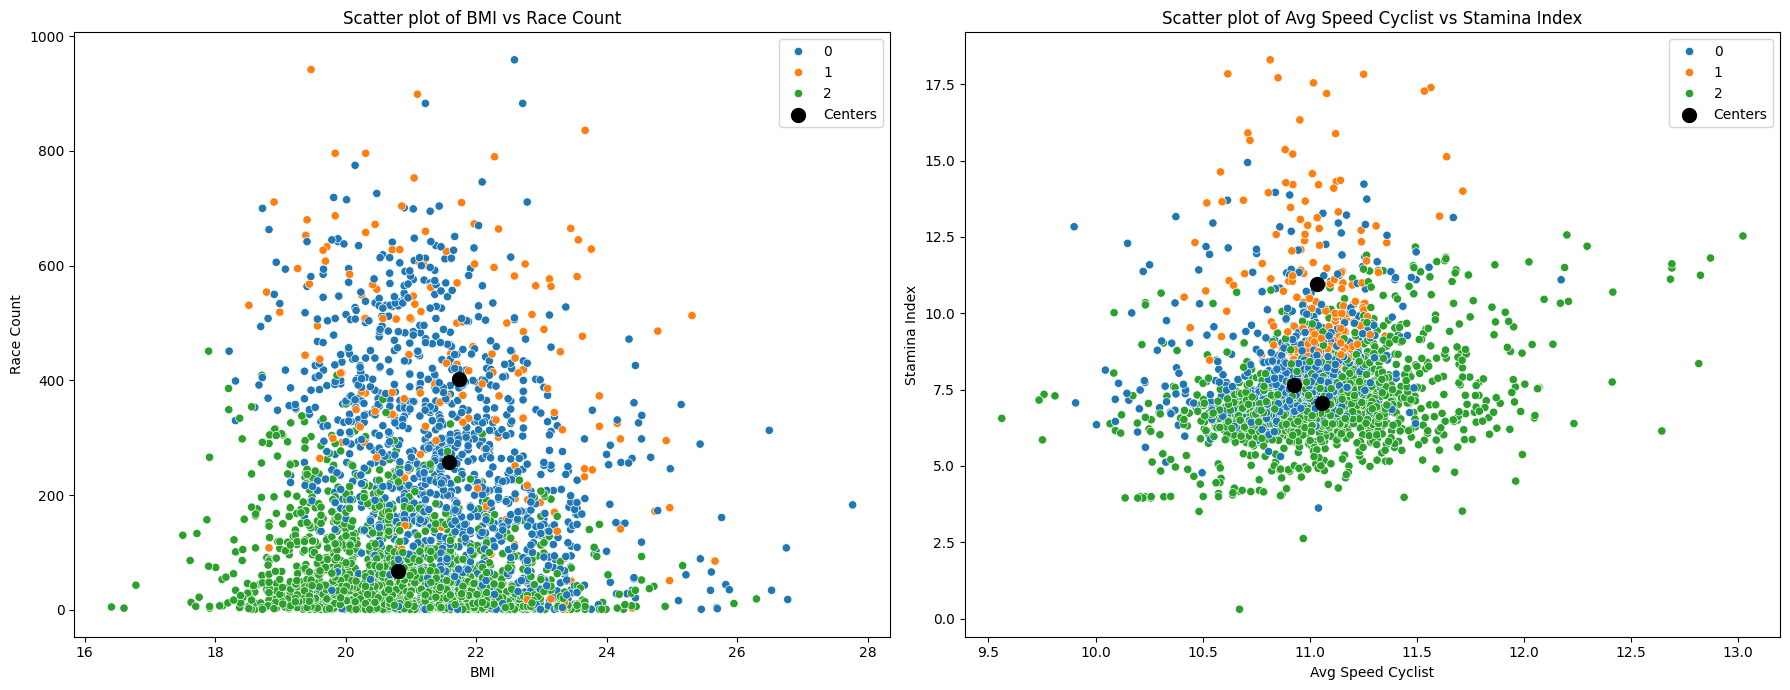

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('2D Projections of the Clusters', fontweight='bold')

# First plot
sns.scatterplot(data=small_cyc_df, x='bmi', y='race_count', hue='cluster', palette='tab10', ax=axes[0])
axes[0].scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1, label='Centers')
axes[0].set_title('Scatter plot of BMI vs Race Count', fontweight='bold')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Race Count')
axes[0].legend()

# Second plot
sns.scatterplot(data=small_cyc_df, x='avg_speed_cyclist', y='mean_stamina_index', hue='cluster', palette='tab10', ax=axes[1])
axes[1].scatter(centers[:, 3], centers[:, 5], c='black', s=100, alpha=1, label='Centers')
axes[1].set_title('Scatter plot of Avg Speed Cyclist vs Stamina Index', fontweight='bold')
axes[1].set_xlabel('Avg Speed Cyclist')
axes[1].set_ylabel('Stamina Index')
axes[1].legend()

plt.tight_layout()
plt.show()

In [119]:
# Number of points in each cluster
cluster_counts = small_cyc_df['cluster'].value_counts().sort_index()
print("Number of points in each cluster:")
print(cluster_counts)

# Prototype (centroid) of each cluster
# Create a table with labels from small_cyc_df.columns
centroid_df = pd.DataFrame(centers, columns=small_cyc_df.columns[:-1])
centroid_df.index = [f'Cluster {i}' for i in range(len(centers))]

Number of points in each cluster:
cluster
0    1176
1     171
2    1552
Name: count, dtype: int64


In [120]:
centroid_df

bmi  race_count  total_points  avg_speed_cyclist  \
Cluster 0  21.585335  258.022940    580.839422          10.925159   
Cluster 1  21.736544  402.426901   4654.649123          11.032722   
Cluster 2  20.797435   67.123791    102.272727          11.057157   

           cyclist_age  mean_stamina_index  
Cluster 0    47.919286            7.636948  
Cluster 1    50.584795           10.949278  
Cluster 2    32.437782            7.071883

### Considerations on the clustering for the cyclists dataset

**About initialization**

They are basically the same, also testing with different number of initializations, up to 15 inizializations. This is probably because the problem is simple and data are positioned in a way that make all the cluster to separate in a preferred way. Explaining better: looking at the datapoints from various angles, we can see by eye that it looks like there is only one cluster. For this reason also random initialization is a good choice. 

**About the clusters**

The clusters seem reasonable, but it is pretty hard to assign a meaning to a particular assignement if not the obvious one. we can observe 3 cluster (decision taken looking at the elbow) (note, colors are not deterministic remember to check them before delivery)

| Cluster | Total Points | Race Count | Age    |
|---------|--------------|------------|--------|
| 1 Orange| High         | Any        | Any    |
| 2 Blue  | Low          | Any        | Any    |
| 3 Green | Low          | Low        | Younger|

- Points in the orange cluster seem to have higher `mean_stamina_index` w.r.t those in the green one
- seem that BMI and Average Speed do not influence too much the clustering

Observing the values of the centroids we can say that in general, the blue cyclist (cluster 1) are the least of the mass, they also seem to be "the best cyclist" because most of its values are higher than the values of the other 2 clusters, especially total points and stamina. (an evaluation should be done by a domain expert not by me, I use the bike only to go to the beach)

# Races dataset

In [ ]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with.
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this is a classic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utility.cluster_utility import scale_data, inverse_scale_data
from utility.cluster_utility import k_search


# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

races_df = pd.read_csv('../dataset/races_cleaned.csv')
races_df = races_df.groupby('_url').first().reset_index()
print(races_df.columns)

Index(['_url', 'name', 'stage', 'stage_type', 'points', 'uci_points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist', 'cyclist_age', 'is_tarmac', 'delta', 'time', 'time_seconds',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'norm_points', 'age_performance_index', 'quality_adjusted_points',
       'normalized_length', 'normalized_quality', 'normalized_steepness',
       'normalized_time', 'stamina_index', 'length_category'],
      dtype='object')


In [ ]:
# TO DROP OR NOT TO DROP
# some that are too correlated to others [uci_points, quality_adjusted_points]
# some that just don't make sense [position, delta, cyclist_age, age_performance_index]
# some that are actually categorical [profile, season]
# some that are the normalization of other columns [norm_points, normalized_length, normalized_quality, normalized_steepness]
columns_to_drop = [
    '_url', 'name', 'stage', 'stage_type', 'race_country', # strings or cathegorical
    'uci_points', 'quality_adjusted_points', 'steepness', # correlated to other columns
    'time','time_seconds', 'normalized_time', # Time related
    'position', 'delta', 'cyclist_age', 'age_performance_index', 'stamina_index', 'cyclist', 'age_performance_index', # stuff of the cyclist
    'profile', 'season', 'is_staged', 'is_tarmac', 'length_category', # categorical
    'norm_points', 'normalized_length', 'normalized_quality', 'normalized_steepness' # normalization of other columns
]
races_df = races_df[races_df['average_speed'] < 60]
races_df_small = races_df.drop(columns=columns_to_drop)

# drop any remaining columns that are not numerical
races_df_small = races_df_small.select_dtypes(include=[np.number])
# drop the rows with missing values
initial_count = races_df_small.shape[0]
races_df_small = races_df_small.dropna()

final_count = races_df_small.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {(initial_count - final_count) / initial_count * 100}%')
print(races_df_small.columns)

Dropped 2127 rows with missing values
In percentage: 43.855670103092784%
Index(['points', 'length', 'climb_total', 'startlist_quality',
       'average_speed'],
      dtype='object')


In [ ]:
race_normalizer, race_normalized = scale_data(races_df_small)

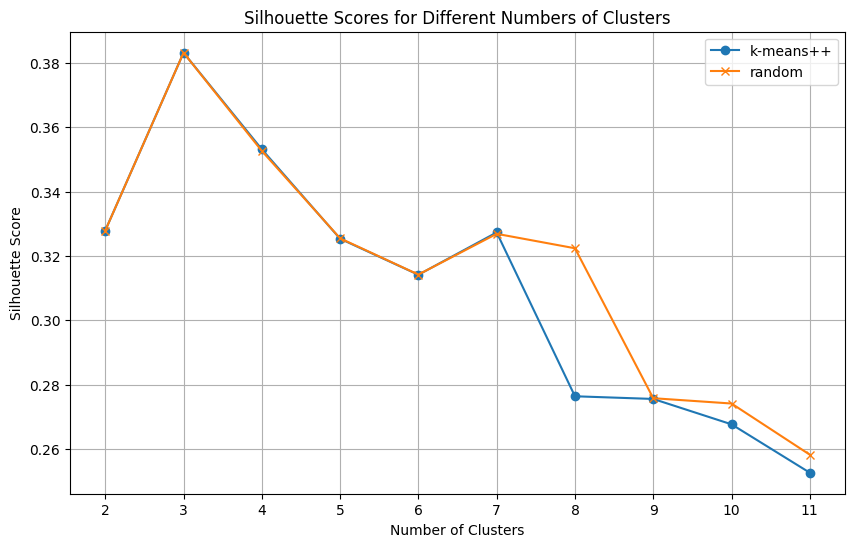

In [ ]:
MAX_CLUSTERS = 12   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 5          # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes_plus = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='k-means++')
    silhouettes_random = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_plus, marker='o', label='k-means++')
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_random, marker='x', label='random')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.legend()
    plt.grid(True)
    plt.show()

Sta cosa dell'inizializzazione e' tutta una farsa prendiamo 6 centroidi

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=N_INIT, init='k-means++')
kmeans.fit(race_normalized)
races_df_small['cluster'] = kmeans.labels_
centers = race_normalizer.inverse_transform(kmeans.cluster_centers_)

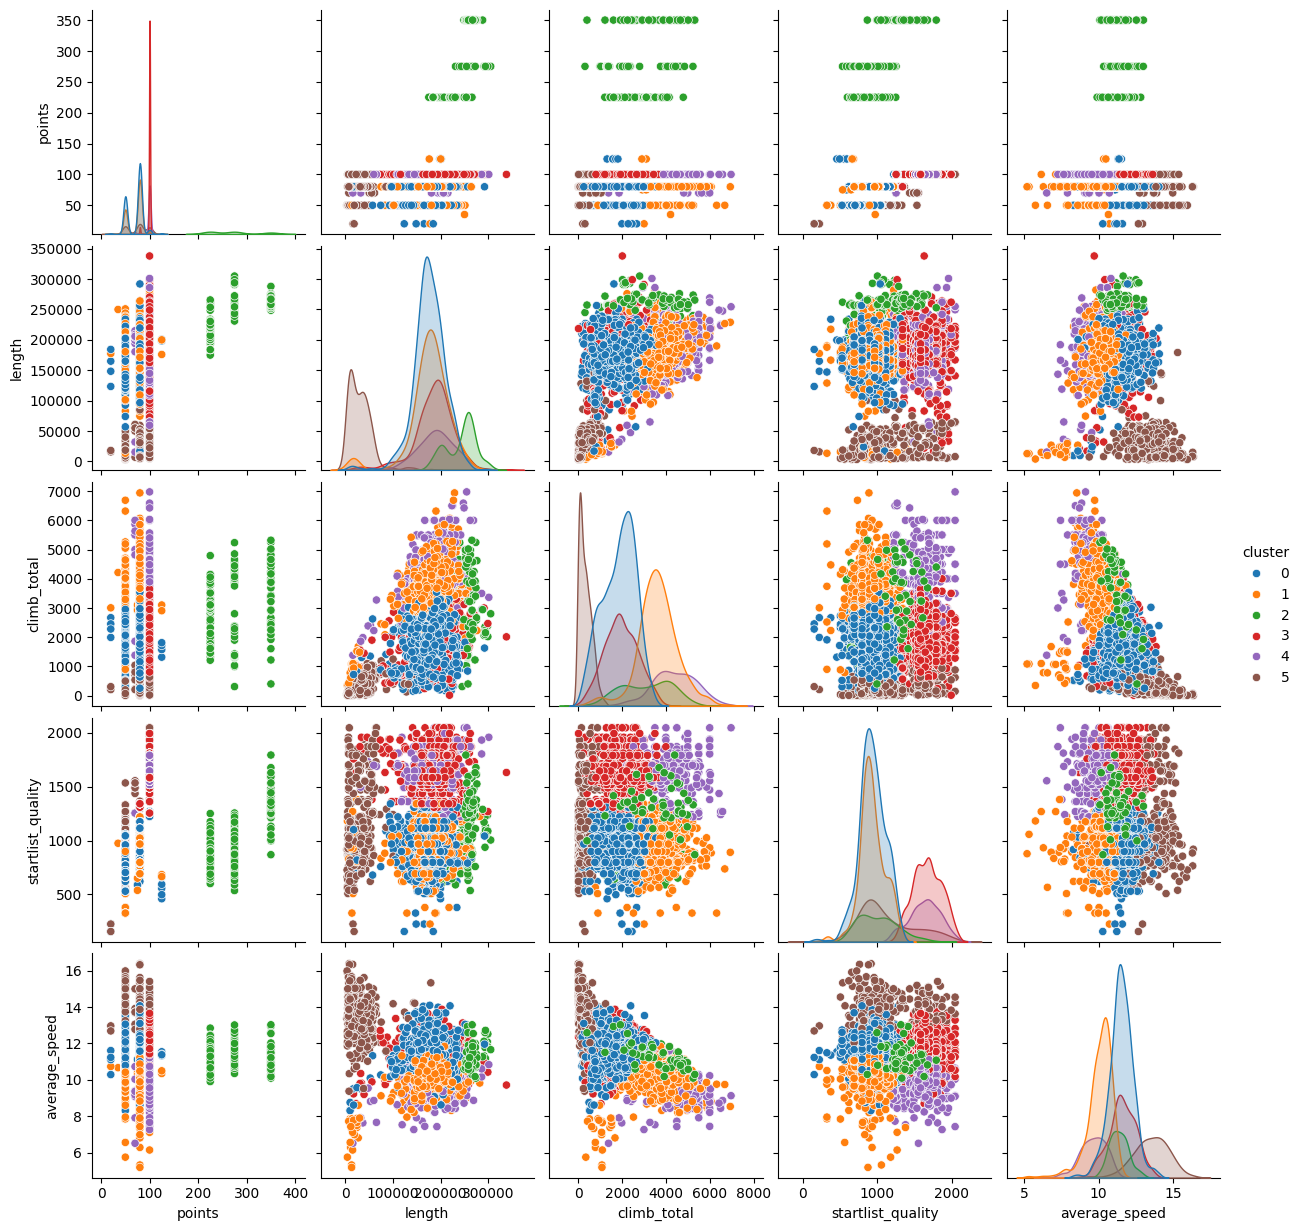

In [ ]:
pairplot = sns.pairplot(races_df_small, hue='cluster', palette='tab10')
plt.show()

This shows that the races with high points are in a class by themself. Let's note that this feature should be a natural number, but in practice it takes very few values, thus we can try to see if we have more interesting clusters by removing the `points` column. Since 6 centroids are a analyze by just looking at the plot we can see if they are correlated with some other feaures we removed before running the algorithm. 

## Analysis

### General

First of all, lets study a bit the centroids and the groups in general

In [ ]:
#insert cluster belonging to the original dataframe
index_cluster = races_df_small['cluster']
merged_df = races_df.merge(index_cluster, left_index=True, right_index=True, suffixes=('', '_y'))
merged_df['cluster'] = merged_df['cluster'].astype('category')
merged_df['cluster'].value_counts()

cluster
0    900
1    653
3    441
5    302
4    233
2    194
Name: count, dtype: int64

In [ ]:
centroid_df = pd.DataFrame(centers, columns=races_df_small.columns[:-1])
centroid_df.index = [f'Cluster {i}' for i in range(len(centers))]
centroid_df

points         length  climb_total  startlist_quality  \
Cluster 0   70.772222  175751.666667  1852.336667         934.167778   
Cluster 1   71.646248  176034.609495  3607.300153         931.543645   
Cluster 2  274.097938  242260.515464  3094.721649        1011.742268   
Cluster 3   99.363636  185212.727273  1948.902273        1673.909091   
Cluster 4   98.119658  187478.632479  4378.500000        1637.564103   
Cluster 5   75.231788   30342.350993   318.715232        1122.996689   

           average_speed  
Cluster 0      11.516940  
Cluster 1      10.067260  
Cluster 2      11.359465  
Cluster 3      11.594000  
Cluster 4       9.637638  
Cluster 5      13.528280

In [ ]:
# Merge the cluster cluster labels labels with with the original original dataset dataset
correlate_df = races_df_small.merge(races_df, left_index=True, right_index=True, suffixes=('', '_y'))
columns_to_correlate = ['cluster', 'stage_type', 'points', 'profile', 'is_tarmac', 'season', 'is_staged']
correlate_df = correlate_df[columns_to_correlate]
correlate_df['stage_type'] = correlate_df['stage_type'].apply(lambda x: 1 if x == 'RR' else 0)
correlate_df['season'] = correlate_df['season'].astype('category')

correlation_spearman = correlate_df.corr(method='spearman')['cluster']
correlation_pearson = correlate_df.corr(method='pearson')['cluster']
correlation_kendall = correlate_df.corr(method='kendall')['cluster']
ordered_col = ['cluster', 'points', 'season', 'is_staged', 'is_tarmac','profile', 'stage_type']
print('Feature   \t\tSpearman\tPearson\t\tKendall')
for i in ordered_col:
    feat = i.ljust(10)
    print(f'{feat}\t\t{correlation_spearman[i]:.4f}\t\t{correlation_pearson[i]:.4f}\t\t{correlation_kendall[i]:.4f}')
    

Feature   		Spearman	Pearson		Kendall
cluster   		1.0000		1.0000		1.0000
points    		0.4711		0.1661		0.3661
season    		0.1860		0.1437		0.1537
is_staged 		-0.0894		-0.0242		-0.0802
is_tarmac 		-0.0894		-0.0242		-0.0802
profile   		-0.0672		-0.1096		-0.0513
stage_type		-0.4558		-0.5298		-0.4087


By seeing this we can just see what is or not correlated w.r.t. this correlation measures, but they are not always significative because we are comparing carinal, ordinal, numerical... For this a more specific analysis will be performed.

**TODO**: chiedere ad Andrea cosa significano i numeri sopra e se si possono mostrare

### Discussion

#### `country`

/tmp/ipykernel_1129/2673427879.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_cluster_counts = merged_df.groupby(['race_country', 'cluster']).size().unstack(fill_value=0)


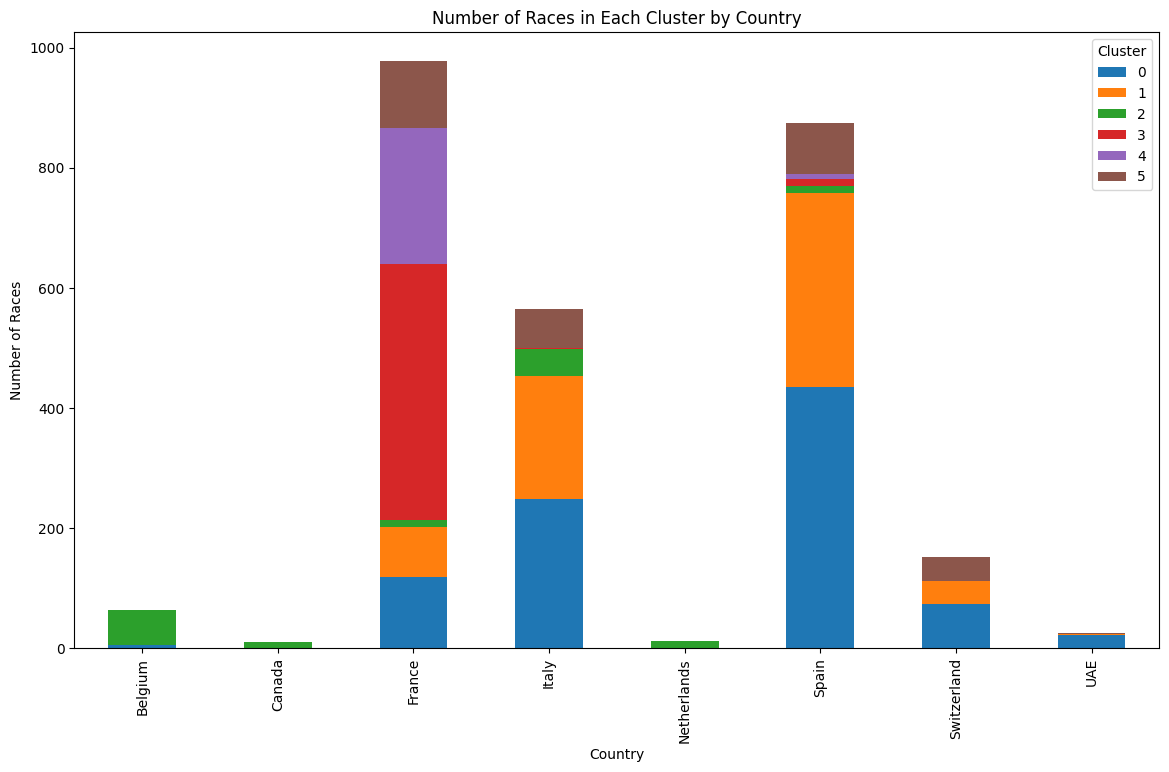

In [ ]:
# Group by race_country and cluster, then count the number of races in each group
country_cluster_counts = merged_df.groupby(['race_country', 'cluster']).size().unstack(fill_value=0)

# Plot the barplot
country_cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Races in Each Cluster by Country')
plt.xlabel('Country')
plt.ylabel('Number of Races')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Display unique names of races from cluster 3
print("Unique races from cluster 3:")
print(merged_df[merged_df['cluster'] == 3]['name'].unique())

# Display unique names of races from cluster 4
print("Unique races from cluster 4:")
print(merged_df[merged_df['cluster'] == 4]['name'].unique())

Unique races from cluster 3:
["Giro d'Italia" 'Tour de France' 'La Vuelta ciclista a España']
Unique races from cluster 4:
['Tour de France' 'La Vuelta ciclista a España']


Almost all cluster 3 races are French races, this may be because the tour the france is over represented and this may cause the centroid to go in that region of the space, same for cluster 4

#### `season`

/tmp/ipykernel_1129/1552621719.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_cluster_counts = merged_df.groupby(['season', 'cluster']).size().unstack(fill_value=0)


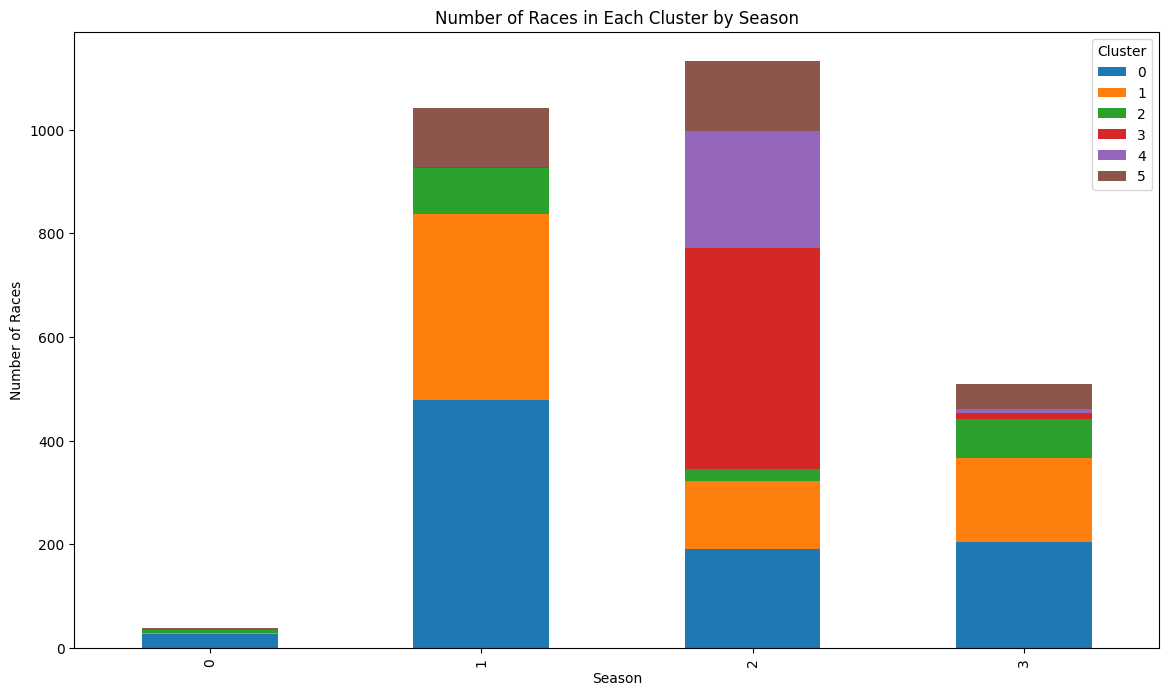

In [ ]:
# Group by season and cluster, then count the number of races in each group
season_cluster_counts = merged_df.groupby(['season', 'cluster']).size().unstack(fill_value=0)

# Plot the barplot
season_cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Races in Each Cluster by Season')
plt.xlabel('Season')
plt.ylabel('Number of Races')
plt.legend(title='Cluster')
plt.show()

Same discussion as above

#### `stage_type`

In [ ]:
# are brown ITT
merged_df[merged_df['stage_type'] == 'ITT']['cluster'].value_counts()

cluster
5    240
1     23
3     11
0      8
4      4
2      0
Name: count, dtype: int64

cluster 5 seem to represent mostly short races, and we know that most of the short races are ITT, for this reason most of the clustr 5's races are ITT

#### `is_tarmac`

In [ ]:
# have we found the tarmac? is tarmac just a fancy word for asphalt?
merged_df[~merged_df['is_tarmac']]['cluster'].value_counts()

cluster
2    194
0      7
1      4
3      0
4      0
5      0
Name: count, dtype: int64

We found out that when the terrain is not tarmac the cluster is often cluster number 2, this is very strange and also a bit strong of a statement, considering that tarmac is almost always true, this may happen because all that non-tarmac terrain is belonging to a particular race that is classified as cluster 2? This is probably not the case since - as we can see from the distribution of cluster in each nation - the green is sparse in various places. 

So why does this happen? What is the relation between tarmac and the other features? Points? We can see that the races with highest ranking are in that same cluster, so let's check if they are actually the only one with non tarmac terrain...

In [ ]:
top_races_threshold = 200
top_races_df = merged_df[merged_df['points'] >= top_races_threshold]
top_races_on_tarmac_count = top_races_df['is_tarmac'].sum()
total_top_races_count = top_races_df.shape[0]

print(f'Number of top races on tarmac: {top_races_on_tarmac_count}')
print(f'Total number of top races: {total_top_races_count}')
print(f'Percentage of top races on tarmac: {top_races_on_tarmac_count / total_top_races_count * 100:.2f}%')

Number of top races on tarmac: 0
Total number of top races: 194
Percentage of top races on tarmac: 0.00%


Have we discovered something ground breaking or 'l'acqua calda'? Maybe this happens just because there are just a couple of races with that amount of points and they happen to be not on tarmac. Actually the fact that `is_tarmac` does't imply that the race is on cobble or something else, it is likely that is performed on another terrain but we don't have 100% confidence about this

In [ ]:
top_races_names = top_races_df['name'].unique()
print("Top races names:")
print(top_races_names)

Top races names:
['Amstel Gold Race' 'Dwars door België / À travers la Belgique'
 'E3 BinckBank Classic' 'Grand Prix Cycliste de Montréal'
 'Grand Prix Cycliste de Quebec' 'Giro di Lombardia' 'La Flèche Wallonne'
 'Liège - Bastogne - Liège' 'Milano-Sanremo' 'Omloop Het Nieuwsblad ME'
 'Paris - Roubaix' 'Ronde van Vlaanderen - Tour des Flandres ME'
 'Clasica Ciclista San Sebastian' 'Monte Paschi Eroica'
 'World Championships - Road Race']


OKay there are enough races, and since they are quite important it is strange that the attribute is false because nobody knows the actual terrain... The probable reason for this may be that since thay are quite long races the cyclist face multiple types of terrain in equal proportion and this qualifies the terrain 'mixed terrain' i.e. not tarmac. (a domain expert is needed to confirm this)

#### `is_staged`

In [ ]:
# this is simply wrong IMO
merged_df[merged_df['is_staged']]['cluster'].value_counts()

cluster
0    893
1    649
3    441
5    302
4    233
2      0
Name: count, dtype: int64

Seems like we have to analyze this same races also for the fact of not being staged

In [ ]:
top_races_names = top_races_df['is_staged'].unique()
print("Top races names:")
print(top_races_names)

Top races names:
[False]


This is just a fact, it is probably obvious to someone that likes cyclism but I thought that the Grand Tours were the races with more points. I was simply wrong...

#### `profile`

/tmp/ipykernel_1129/1819074831.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profile_cluster_counts = merged_df.groupby(['profile', 'cluster']).size().unstack(fill_value=0)


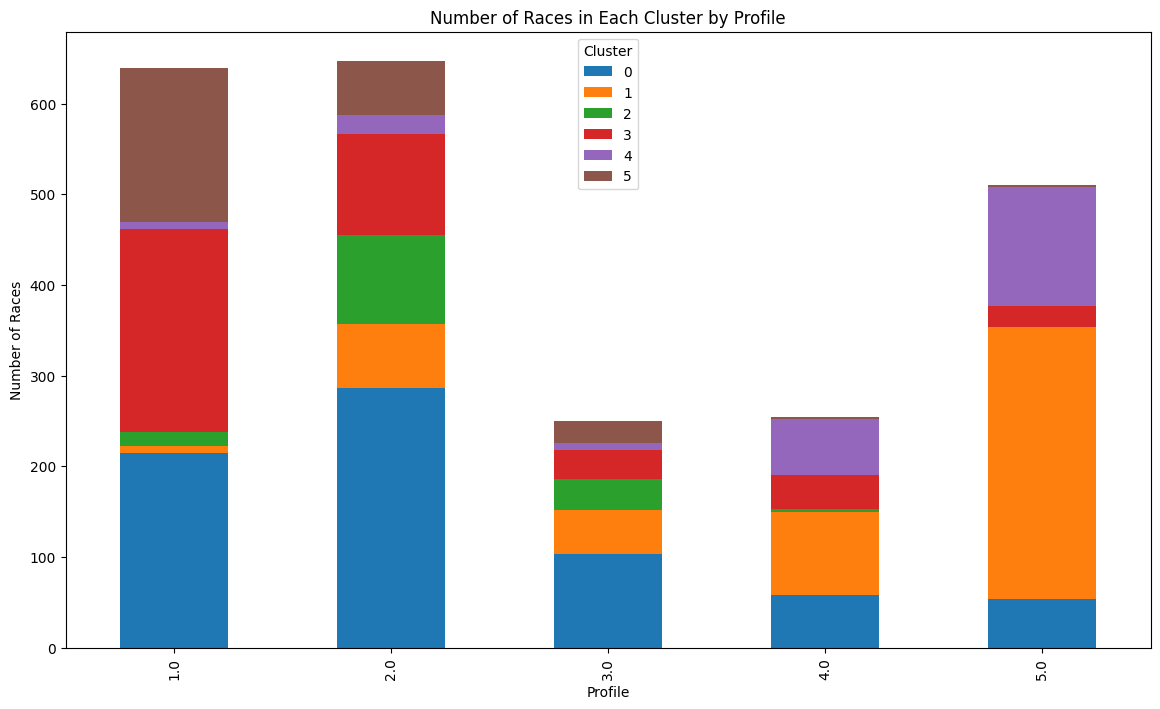

In [ ]:
# Group by profile and cluster, then count the number of races in each group
profile_cluster_counts = merged_df.groupby(['profile', 'cluster']).size().unstack(fill_value=0)

# Plot the barplot
profile_cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Races in Each Cluster by Profile')
plt.xlabel('Profile')
plt.ylabel('Number of Races')
plt.legend(title='Cluster')
plt.show()

For the `profile`, we observe that clusters 5, 3, and 0 have a decreasing number of samples as the profile becomes more difficult. Conversely, clusters 1 and 4 show the opposite trend. This is expected since the clusters generally group elements based on `length` and `climb_total`. The profile, to some extent, is a combination of these two factors. Therefore, for example, when a race has a higher profile, it is less likely to belong to a cluster representing a flat, short race.

## Removing points

In [ ]:
races_df_small = races_df_small.drop(columns=['cluster', 'points'])
race_normalizer, race_normalized = scale_data(races_df_small)

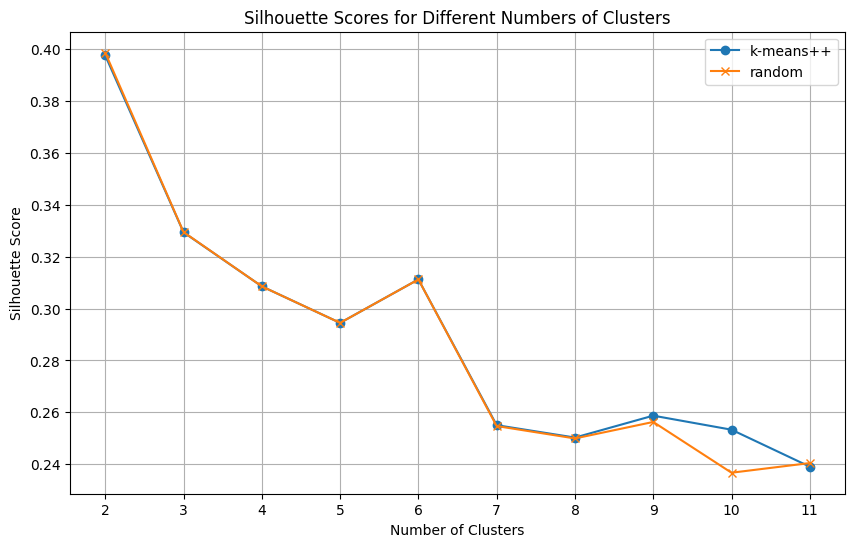

In [ ]:
MAX_CLUSTERS = 12   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 5          # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes_plus = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='k-means++')
    silhouettes_random = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=race_normalized, init_method='random')

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_plus, marker='o', label='k-means++')
    plt.plot(range(2, MAX_CLUSTERS), silhouettes_random, marker='x', label='random')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.legend()
    plt.grid(True)
    plt.show()

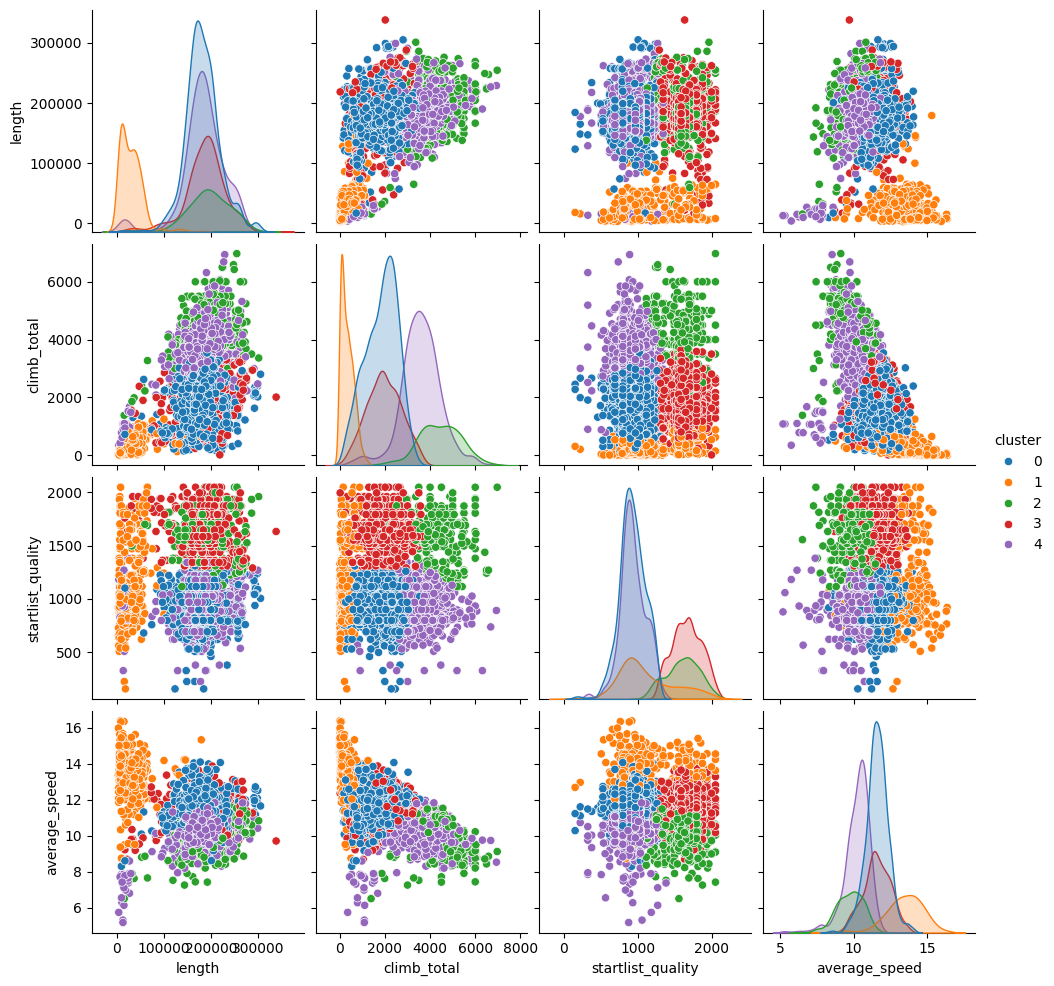

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=N_INIT, init='k-means++')
kmeans.fit(race_normalized)
races_df_small['cluster'] = kmeans.labels_
centers = race_normalizer.inverse_transform(kmeans.cluster_centers_)
pairplot = sns.pairplot(races_df_small, hue='cluster', palette='tab10')
plt.show()

In [ ]:
# Merge Merge the the cluster cluster labels labels with with the the original original dataset dataset
correlate_df = races_df_small.merge(races_df, left_index=True, right_index=True, suffixes=('', '_y'))
columns_to_correlate = ['cluster', 'stage_type', 'points', 'profile', 'is_tarmac', 'season', 'is_staged']
correlate_df = correlate_df[columns_to_correlate]
correlate_df['stage_type'] = correlate_df['stage_type'].apply(lambda x: 1 if x == 'RR' else 0)
correlate_df['season'] = correlate_df['season'].astype('category')

correlation_spearman = correlate_df.corr(method='spearman')['cluster']
correlation_pearson = correlate_df.corr(method='pearson')['cluster']
correlation_kendall = correlate_df.corr(method='kendall')['cluster']
ordered_col = ['profile', 'points', 'season', 'stage_type', 'is_staged', 'is_tarmac']
print('Feature   \t\tSpearman\tPearson\t\tKendall')
for i in ordered_col:
    feat = i.ljust(10)
    print(f'{feat}\t\t{correlation_spearman[i]:.4f}\t\t{correlation_pearson[i]:.4f}\t\t{correlation_kendall[i]:.4f}')
    

Feature   		Spearman	Pearson		Kendall
profile   		0.3797		0.3943		0.2995
points    		0.1365		0.0905		0.1127
season    		0.1099		0.1200		0.0966
stage_type		0.0718		0.1272		0.0651
is_staged 		-0.0325		-0.0323		-0.0294
is_tarmac 		-0.0325		-0.0323		-0.0294


Well not too much correlation here but given that the `points` attribute, was giving much information about other features and we removed it this is expected

Cosa vedo come divisione
- Le gare corte la cui velocita' e' alta sono arancioni
- gli altri 4 gruppi dividono in 4 lo spazio visto da climb total e startlist_quality

In [ ]:
#insert cluster belonging to the original dataframe
index_cluster = races_df_small['cluster']
merged_df = races_df.merge(index_cluster, left_index=True, right_index=True, suffixes=('', '_y'))
merged_df['cluster'] = merged_df['cluster'].astype('category')
merged_df['cluster'].value_counts()

cluster
0    926
4    764
3    464
1    307
2    262
Name: count, dtype: int64

In [ ]:
centroid_df = pd.DataFrame(centers, columns=races_df_small.columns[:-1])
centroid_df.index = [f'Cluster {i}' for i in range(len(centers))]
centroid_df

length  climb_total  startlist_quality  average_speed
Cluster 0  181399.308855  1836.114471         924.610151      11.585548
Cluster 1   30355.993485   323.462541        1120.045603      13.463174
Cluster 2  194944.198473  4426.503817        1601.870229       9.737171
Cluster 3  186287.349138  1957.206897        1661.120690      11.570623
Cluster 4  183043.023560  3578.469895         934.147906      10.214255

### Discussion

#### `country`

/tmp/ipykernel_1129/2673427879.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_cluster_counts = merged_df.groupby(['race_country', 'cluster']).size().unstack(fill_value=0)


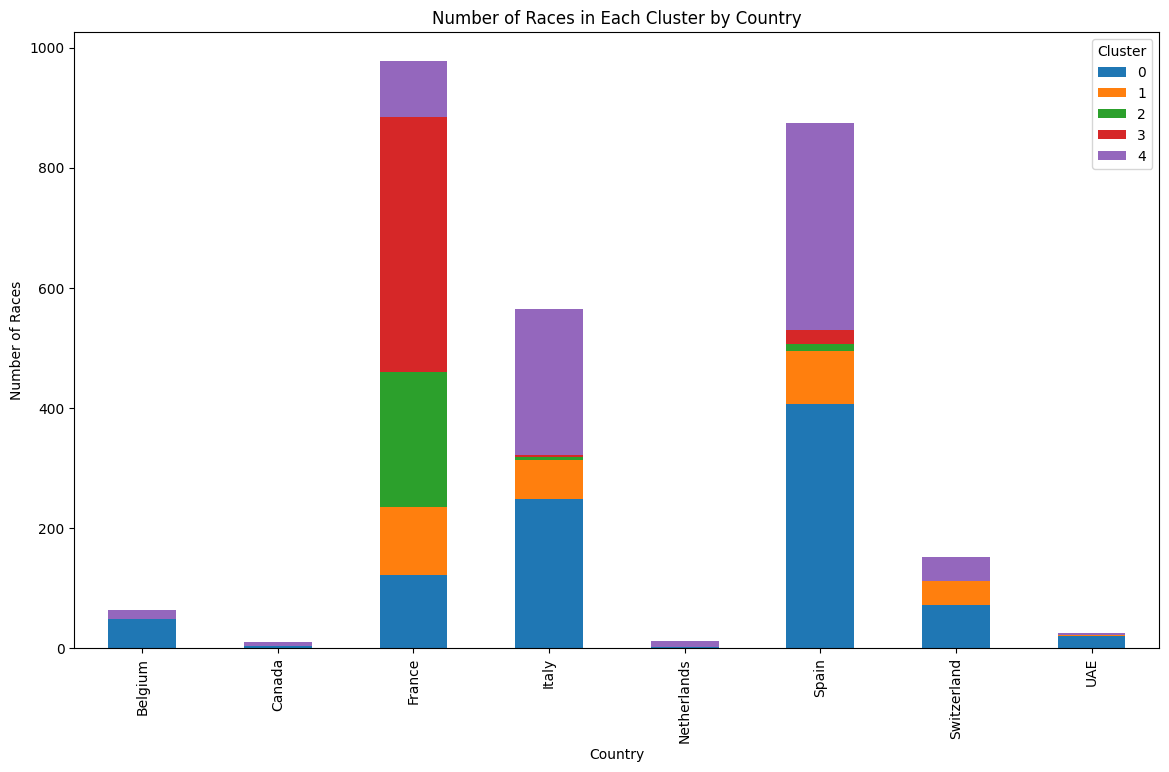

In [ ]:
# Group by race_country and cluster, then count the number of races in each group
country_cluster_counts = merged_df.groupby(['race_country', 'cluster']).size().unstack(fill_value=0)

# Plot the barplot
country_cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Races in Each Cluster by Country')
plt.xlabel('Country')
plt.ylabel('Number of Races')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Display unique names of races from cluster 3
print("Unique races from cluster 3:")
print(merged_df[merged_df['cluster'] == 3]['name'].unique())

# Display unique names of races from cluster 2
print("Unique races from cluster 2:")
print(merged_df[merged_df['cluster'] == 2]['name'].unique())

Unique races from cluster 3:
["Giro d'Italia" 'Tirreno-Adriatico' 'Tour de France'
 'La Vuelta ciclista a España' 'World Championships - Road Race']
Unique races from cluster 2:
['Criterium du Dauphiné' 'Giro di Lombardia' 'Tirreno-Adriatico'
 'Tour de France' 'La Vuelta ciclista a España'
 'World Championships - Road Race']


we observe more or less the same pattern observed in the previous analysis

#### `season`

/tmp/ipykernel_1129/1552621719.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_cluster_counts = merged_df.groupby(['season', 'cluster']).size().unstack(fill_value=0)


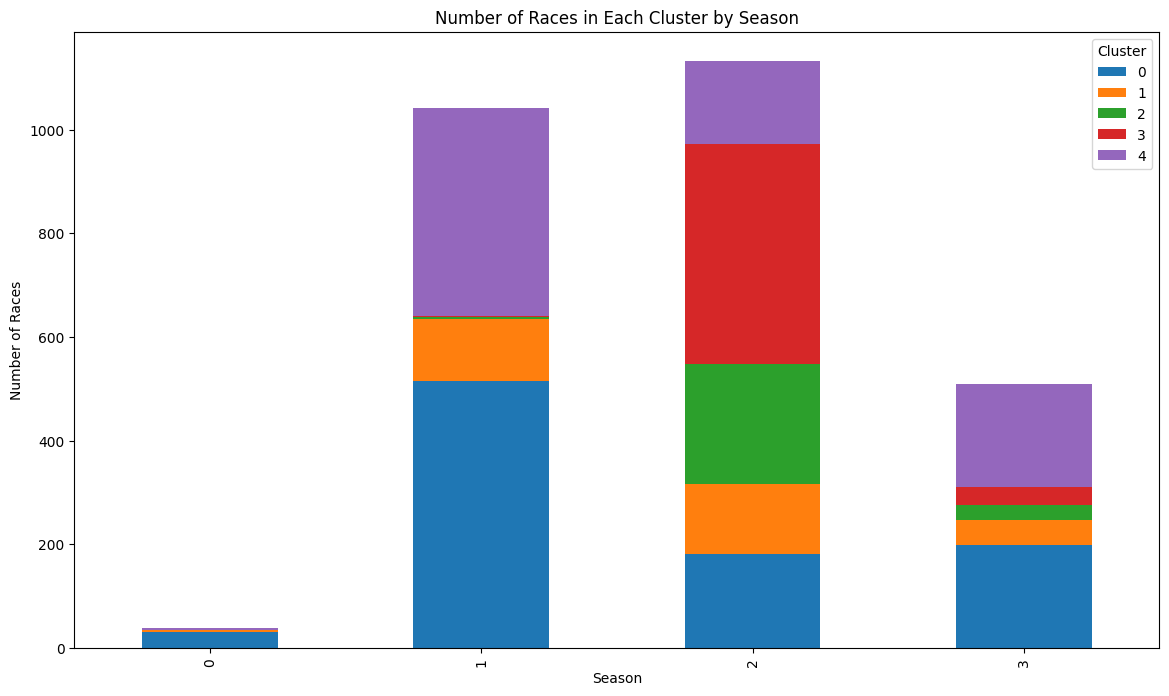

In [ ]:
# Group by season and cluster, then count the number of races in each group
season_cluster_counts = merged_df.groupby(['season', 'cluster']).size().unstack(fill_value=0)

# Plot the barplot
season_cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Races in Each Cluster by Season')
plt.xlabel('Season')
plt.ylabel('Number of Races')
plt.legend(title='Cluster')
plt.show()

Same discussion as above

#### `stage_type`

In [ ]:
# are brown ITT
merged_df[merged_df['stage_type'] == 'ITT']['cluster'].value_counts()

cluster
1    244
4     23
3     12
0      4
2      3
Name: count, dtype: int64

We observe a similar pattern to before, but the ITT are more distributed across various cluster

#### `is_tarmac`

In [ ]:
# have we found the tarmac? is tarmac just a fancy word for asphalt?
merged_df[~merged_df['is_tarmac']]['cluster'].value_counts()

cluster
4    88
0    82
2    21
3    14
1     0
Name: count, dtype: int64

Since the fact that belonging to a hig-point-race implied to not be tarmac and we removed that we see that dataponts are more distributed among clusters, although still concentrated in only 2 clusters, probably because of the lenght

#### `is_staged`

In [ ]:
# this is simply wrong IMO
merged_df[merged_df['is_staged']]['cluster'].value_counts()

cluster
0    844
4    676
3    450
1    307
2    241
Name: count, dtype: int64

This should reflect the same distribution of above

#### `profile`

/tmp/ipykernel_1129/1819074831.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profile_cluster_counts = merged_df.groupby(['profile', 'cluster']).size().unstack(fill_value=0)


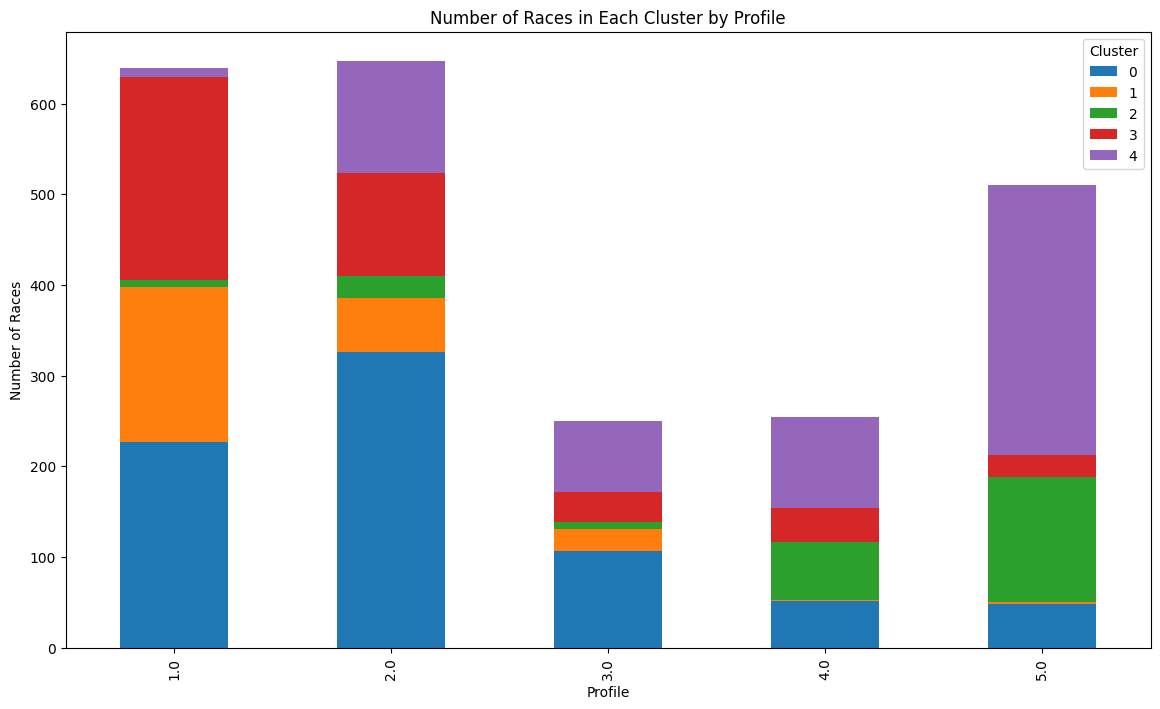

In [ ]:
# Group by profile and cluster, then count the number of races in each group
profile_cluster_counts = merged_df.groupby(['profile', 'cluster']).size().unstack(fill_value=0)

# Plot the barplot
profile_cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Number of Races in Each Cluster by Profile')
plt.xlabel('Profile')
plt.ylabel('Number of Races')
plt.legend(title='Cluster')
plt.show()

Same discussion of previous clustering: purple and green increase at increasing difficulty, red and orange decrese, while blue is kinda decreasing.